In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from torchvision.utils import save_image
from PIL import Image
import os
from tqdm import tqdm
import sys
import pandas as pd

In [9]:
import os
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from torchvision import transforms, utils
from tqdm import tqdm


In [1]:
print("Test commencé !")

Test commencé !


In [22]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()

        self.net = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(64, 3, 3, padding=1),
            nn.Tanh()  # sortie [-1, 1]
        )

    def forward(self, x):
        return self.net(x)


In [11]:
class ImageDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.images = sorted([
            f for f in os.listdir(image_dir)
            if f.lower().endswith((".png", ".jpg", ".jpeg"))
        ])
        self.transform = transform

        if len(self.images) == 0:
            raise RuntimeError(f"Aucune image trouvée dans {image_dir}")

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        path = os.path.join(self.image_dir, self.images[idx])
        img = Image.open(path).convert("RGB")

        if self.transform:
            img = self.transform(img)

        return img


In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

IMAGE_DIR = "../data/train/degraded_images"   # images sorties du VAE
EPOCHS = 2
BATCH_SIZE = 8
LR = 1e-4


Device: cpu


In [21]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=(0.5, 0.5, 0.5),
        std=(0.5, 0.5, 0.5)
    )
])


In [27]:
from torch.utils.data import Subset
import random

MAX_IMAGES = 1000

indices = list(range(len(dataset)))
random.shuffle(indices)
indices = indices[:MAX_IMAGES]

small_dataset = Subset(dataset, indices)

loader = DataLoader(
    small_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0
)

print("Nombre d'images utilisées :", len(small_dataset))


Nombre d'images utilisées : 1000


In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()

        self.block = nn.Sequential(
            nn.Conv2d(channels, channels, 3, padding=1),
            nn.BatchNorm2d(channels),
            nn.ReLU(inplace=True),

            nn.Conv2d(channels, channels, 3, padding=1),
            nn.BatchNorm2d(channels),
        )

    def forward(self, x):
        return torch.relu(x + self.block(x))


In [ ]:
model = SimpleCNN().to(device)
criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=LR)

os.makedirs("checkpoints", exist_ok=True)

for epoch in range(EPOCHS):
    model.train()
    epoch_loss = 0

    loop = tqdm(loader, desc=f"Epoch {epoch+1}/{EPOCHS}")

    for imgs in loop:
        imgs = imgs.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, imgs)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        loop.set_postfix(loss=loss.item())

    avg_loss = epoch_loss / len(loader)
    print(f"Epoch {epoch+1} | Loss moyenne: {avg_loss:.4f}")

    torch.save(model.state_dict(), "checkpoints/cnn_last.pth")

print("✅ Entraînement terminé")


Epoch 1/2:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 1/2: 100%|██████████| 125/125 [06:52<00:00,  3.30s/it, loss=0.0373]


Epoch 1 | Loss moyenne: 0.1267


Epoch 2/2:  22%|██▏       | 27/125 [01:23<04:31,  2.77s/it, loss=0.0237]

In [ ]:
class ElegantCNN(nn.Module):
    def __init__(self):
        super().__init__()

        self.entry = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            nn.ReLU(inplace=True)
        )

        self.res_blocks = nn.Sequential(
            ResidualBlock(64),
            ResidualBlock(64),
            ResidualBlock(64),
            ResidualBlock(64),
            ResidualBlock(64),
        )

        self.exit = nn.Sequential(
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 3, 3, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.entry(x)
        x = self.res_blocks(x)
        x = self.exit(x)
        return x


In [ ]:
model = ElegantCNN().to(device)
criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=LR)

os.makedirs("checkpoints", exist_ok=True)

for epoch in range(EPOCHS):
    model.train()
    epoch_loss = 0

    loop = tqdm(loader, desc=f"Epoch {epoch+1}/{EPOCHS}")

    for imgs in loop:
        imgs = imgs.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, imgs)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        loop.set_postfix(loss=loss.item())

    avg_loss = epoch_loss / len(loader)
    print(f"Epoch {epoch+1} | Loss moyenne : {avg_loss:.4f}")

    torch.save(model.state_dict(), "checkpoints/elegant_cnn_last.pth")

print("✅ Entraînement terminé")


In [25]:
model.eval()
output_dir = "cnn_outputs"
os.makedirs(output_dir, exist_ok=True)

with torch.no_grad():
    for i, img in enumerate(dataset):
        img = img.unsqueeze(0).to(device)
        out = model(img)

        # dénormalisation [-1,1] → [0,1]
        out = out * 0.5 + 0.5

        utils.save_image(out, os.path.join(output_dir, f"cnn_{i}.png"))

print("✅ Images sauvegardées dans", output_dir)


KeyboardInterrupt: 

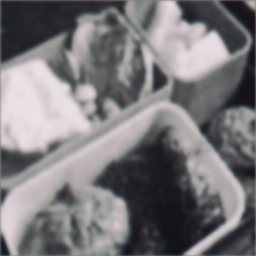

In [26]:
from IPython.display import display

sample_path = os.path.join("cnn_outputs", "cnn_0.png")
display(Image.open(sample_path))


In [4]:
class RestorationCNN(nn.Module):
    def __init__(self):
        super().__init__()

        # Encoder
        self.enc1 = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1), nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1), nn.ReLU()
        )
        self.pool1 = nn.MaxPool2d(2)

        self.enc2 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1), nn.ReLU()
        )
        self.pool2 = nn.MaxPool2d(2)

        # Bottleneck
        self.mid = nn.Sequential(
            nn.Conv2d(128, 256, 3, padding=1), nn.ReLU(),
            nn.Conv2d(256, 256, 3, padding=1), nn.ReLU()
        )

        # Decoder
        self.up2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec2 = nn.Sequential(
            nn.Conv2d(256, 128, 3, padding=1), nn.ReLU()
        )

        self.up1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec1 = nn.Sequential(
            nn.Conv2d(128, 64, 3, padding=1), nn.ReLU()
        )

        self.out = nn.Conv2d(64, 3, 1)

    def forward(self, x):
        e1 = self.enc1(x)
        p1 = self.pool1(e1)

        e2 = self.enc2(p1)
        p2 = self.pool2(e2)

        m = self.mid(p2)

        d2 = self.up2(m)
        d2 = self.dec2(torch.cat([d2, e2], dim=1))

        d1 = self.up1(d2)
        d1 = self.dec1(torch.cat([d1, e1], dim=1))

        return torch.tanh(self.out(d1))


In [5]:
train_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])


In [6]:
criterion_l1 = nn.L1Loss()
criterion_mse = nn.MSELoss()

def cnn_loss(pred, target):
    return criterion_l1(pred, target) + 0.5 * criterion_mse(pred, target)


In [ ]:
    
model = RestorationCNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=2e-4)

for epoch in range(10):
    model.train()
    epoch_loss = 0

    for degraded, clean in train_loader:
        degraded, clean = degraded.to(device), clean.to(device)

        optimizer.zero_grad()
        restored = model(degraded)
        loss = cnn_loss(restored, clean)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    print(f"Epoch {epoch+1} | Loss: {epoch_loss/len(train_loader):.4f}")


NameError: name 'train_loader' is not defined